In [1]:
!pip install nltk==3.6.5
!pip install sklearn==0.0

In [2]:
import string
import numpy as np
import pandas as pd
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, pow
from pyspark.sql.types import StringType
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, Tokenizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
spark = SparkSession \
    .builder \
    .getOrCreate()
print(spark)

Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-48834fbf-5918-4278-bbf8-5e6d805a0b31;1.0
	confs: [default]


:: loading settings :: url = jar:file:/usr/local/spark-3.2.0-bin-hadoop3.2/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 230ms :: artifacts dl 13ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   4   |   0   |   0   |   0   ||   4   |   0   |
	---------------------------------------------------------------------
:: retrieving :

In [4]:
crypto_df = spark.read.format("mongo").option("uri","mongodb://mongo/seng550.crypto").load()
headers_df = spark.read.format("mongo").option("uri","mongodb://mongo/seng550.headers").load()

In [5]:
crypto_df.show(3)

+--------------------+------------------+----------+-----------------+
|                 _id|             close|      date|             open|
+--------------------+------------------+----------+-----------------+
|{619f20a05fec62ac...|        61238.6222|2021-10-23|60690.28731420007|
|{619f20a15fec62ac...| 60694.00000650834|2021-10-22|62196.96438572152|
|{619f20a15fec62ac...|62298.093007718286|2021-10-21|65961.04976056097|
+--------------------+------------------+----------+-----------------+
only showing top 3 rows



In [6]:
headers_df.show(3)

+--------------------+----------+--------------------+
|                 _id|      date|            headline|
+--------------------+----------+--------------------+
|{619f1214b82509cf...|2021-08-01|Family speaks out...|
|{619f1215b82509cf...|2021-08-01|China invasion of...|
|{619f1215b82509cf...|2021-08-01|US digital paymen...|
+--------------------+----------+--------------------+
only showing top 3 rows



In [7]:
crypto_df = crypto_df.withColumn('change', 1 - (col('close') / col('open')))
crypto_df.show(3)

+--------------------+------------------+----------+-----------------+--------------------+
|                 _id|             close|      date|             open|              change|
+--------------------+------------------+----------+-----------------+--------------------+
|{619f20a05fec62ac...|        61238.6222|2021-10-23|60690.28731420007|-0.00903496935120...|
|{619f20a15fec62ac...| 60694.00000650834|2021-10-22|62196.96438572152| 0.02416459378776714|
|{619f20a15fec62ac...|62298.093007718286|2021-10-21|65961.04976056097| 0.05553211730467056|
+--------------------+------------------+----------+-----------------+--------------------+
only showing top 3 rows



In [8]:
def clean_header(header):
    # Headers are small, so local process is ok.
    porter = PorterStemmer()
    header = header.strip()
    if not header:
        return ''
    header = header.translate(str.maketrans('', '', string.punctuation))
    return ' '.join(porter.stem(word) for word in header.split() if word not in ENGLISH_STOP_WORDS)

udf_clean_header = udf(lambda s: clean_header(s), StringType())
headers_df = headers_df.withColumn('headline_clean', udf_clean_header(col('headline')))
headers_df.show(3)

+--------------------+----------+--------------------+--------------------+
|                 _id|      date|            headline|      headline_clean|
+--------------------+----------+--------------------+--------------------+
|{619f1214b82509cf...|2021-08-01|Family speaks out...|famili speak raci...|
|{619f1215b82509cf...|2021-08-01|China invasion of...|china invas taiwa...|
|{619f1215b82509cf...|2021-08-01|US digital paymen...|us digit payment ...|
+--------------------+----------+--------------------+--------------------+
only showing top 3 rows



In [9]:
date_count_df = headers_df.groupby('date').count()
crypto_headline_df = crypto_df.join(headers_df, on='date')\
    .join(date_count_df.withColumnRenamed('count', 'date_count'), on='date')\
    .withColumn('change_normalized', pow(1 + col('change'), 1 / col('date_count')) - 1)\
    .select('date', 'headline_clean', 'change_normalized')
crypto_headline_df.show(3)

+----------+--------------------+--------------------+
|      date|      headline_clean|   change_normalized|
+----------+--------------------+--------------------+
|2021-04-06|asian share eas t...|0.001684018790797...|
|2021-04-06|patient wale uk r...|0.001684018790797...|
|2021-04-06|dubai model dodg ...|0.001684018790797...|
+----------+--------------------+--------------------+
only showing top 3 rows



In [10]:
train_fraction = 0.8
test_fraction = 1 - train_fraction

train_df, test_df = crypto_headline_df.randomSplit([train_fraction, test_fraction], seed=0)

In [11]:
train_df.show(3)

+----------+--------------------+--------------------+
|      date|      headline_clean|   change_normalized|
+----------+--------------------+--------------------+
|2021-03-01|an insan blurri t...|-0.01032963207099...|
|2021-03-01|black amazon exec...|-0.01032963207099...|
|2021-03-01|call perman reope...|-0.01032963207099...|
+----------+--------------------+--------------------+
only showing top 3 rows



In [12]:
test_df.show(3)

+----------+--------------------+--------------------+
|      date|      headline_clean|   change_normalized|
+----------+--------------------+--------------------+
|2021-03-03|7 addit death 542...|-0.00447802498691...|
|2021-03-03|7 addit death 542...|-0.00447802498691...|
|2021-03-03|fema open covid v...|-0.00447802498691...|
+----------+--------------------+--------------------+
only showing top 3 rows



In [13]:
class TfidfModel:
    def __init__(self, tokenizer, cv_model, idf_model):
        self.tokenizer = tokenizer
        self.cv_model = cv_model
        self.idf_model = idf_model

# Use this prefix on temporary columns so they don't conflict with existing columns.
tfidf_comp_prefix = 'kfwsxy'

def fit_tfidf_model(df, input_col, output_col):
    tokenizer = Tokenizer(inputCol=input_col, outputCol=f'{tfidf_comp_prefix}_words')
    words_data = tokenizer.transform(df)

    cv = CountVectorizer(inputCol=f'{tfidf_comp_prefix}_words', outputCol=f'{tfidf_comp_prefix}_raw')
    cv_model = cv.fit(words_data)

    featurized_data = cv_model.transform(words_data)

    idf = IDF(inputCol=f'{tfidf_comp_prefix}_raw', outputCol=output_col)
    idf_model = idf.fit(featurized_data)

    return TfidfModel(tokenizer, cv_model, idf_model)

tfidf_model = fit_tfidf_model(train_df, 'headline_clean', 'headline_features')

In [14]:
def tfidf_vectorize(df, tfidf_model):
    words_data = tfidf_model.tokenizer.transform(df)
    featurized_data = tfidf_model.cv_model.transform(words_data)
    res_df = tfidf_model.idf_model.transform(featurized_data)
    return res_df\
        .drop(f'{tfidf_comp_prefix}_words')\
        .drop(f'{tfidf_comp_prefix}_raw').drop('headline_clean')

vectorized_train_df = tfidf_vectorize(train_df, tfidf_model)
vectorized_test_df = tfidf_vectorize(test_df, tfidf_model)

In [15]:
vectorized_train_df.show(3)

+----------+--------------------+--------------------+
|      date|   change_normalized|   headline_features|
+----------+--------------------+--------------------+
|2021-03-01|-0.01032963207099...|(5599,[316,464,11...|
|2021-03-01|-0.01032963207099...|(5599,[235,251,28...|
|2021-03-01|-0.01032963207099...|(5599,[0,43,232,1...|
+----------+--------------------+--------------------+
only showing top 3 rows



In [16]:
vectorized_test_df.show(3)

+----------+--------------------+--------------------+
|      date|   change_normalized|   headline_features|
+----------+--------------------+--------------------+
|2021-03-03|-0.00447802498691...|(5599,[1,2,3,9,15...|
|2021-03-03|-0.00447802498691...|(5599,[1,2,3,9,15...|
|2021-03-03|-0.00447802498691...|(5599,[0,4,44,739...|
+----------+--------------------+--------------------+
only showing top 3 rows



In [17]:
features_col= 'headline_features'
label_col= 'change_normalized'

reg_params = np.linspace(0, 0.5, 2)

lr = LinearRegression(
    elasticNetParam=0,
    featuresCol=features_col,
    labelCol=label_col,
)

pipeline = Pipeline(stages=[lr])

param_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, reg_params)\
    .build()

evaluator = RegressionEvaluator(labelCol=label_col)

cross_val = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=2,
                           parallelism=8)

cv_model = cross_val.fit(vectorized_train_df)

21/12/18 23:08:23 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/12/18 23:08:23 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
21/12/18 23:08:24 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/18 23:08:24 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [18]:
prediction = cv_model.transform(vectorized_test_df)
prediction.show(3)

+----------+--------------------+--------------------+--------------------+
|      date|   change_normalized|   headline_features|          prediction|
+----------+--------------------+--------------------+--------------------+
|2021-03-03|-0.00447802498691...|(5599,[1,2,3,9,15...|-3.80724591577630...|
|2021-03-03|-0.00447802498691...|(5599,[1,2,3,9,15...|-3.80724591577630...|
|2021-03-03|-0.00447802498691...|(5599,[0,4,44,739...|-2.61966908340775...|
+----------+--------------------+--------------------+--------------------+
only showing top 3 rows



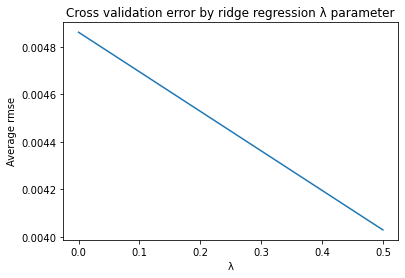

In [19]:
x_label = 'λ'
y_label = 'Average ' + evaluator.getMetricName()
tune_result_df = pd.DataFrame({
    x_label: reg_params,
    y_label: cv_model.avgMetrics})\
    .set_index(['λ'])
plot = tune_result_df.plot.line(
    title='Cross validation error by ridge regression λ parameter',
    ylabel=y_label,
    legend=False)

In [24]:
crypto_df.describe('change').show(truncate=False)

+-------+----------------------+
|summary|change                |
+-------+----------------------+
|count  |301                   |
|mean   |-0.0037206674963974834|
|stddev |0.04336846404173201   |
|min    |-0.18962753904801044  |
|max    |0.13719500387926653   |
+-------+----------------------+

